In [ ]:
import aesara.tensor as at

yerr = df_rebinned["BinError"][mask].values


x_decay = df_rebinned["BinCenter"][mask].values


print("sigma:", yerr.shape)
print("observed:", y.shape)

with pm.Model() as model:
    # Priors for the parameters
    parentThalf = pm.Normal('parentT', mu=8, sigma=80)
    daughter0nThalf = pm.Normal('daugh0nT', mu=90.2, sigma=0.9)
    daughter1nThalf = pm.Normal('daugh1nT', mu=80.4, sigma=0.4)
    daughter2nThalf = pm.Normal('daugh2nT', mu=270, sigma=2)
    # daughter0nThalf =90.2
    # daughter1nThalf = 80.4
    # daughter2nThalf = 270
    initialActivity = pm.Normal('initialActivity', mu=70000, sigma=20000)
    #b= pm.Dirichlet('nBranch', [40, 47, 13])
    # logits = pm.Normal("logits", mu=0, sigma=1, shape=3)
    # b = pm.Deterministic("b", pm.math.softmax(logits))
    b1=pm.Uniform('b1', 0, 1)
    b2=pm.Uniform('b2', 0, 1)
    b0=1-(b1+b2)
    
    pm.Potential("constraint", at.switch(b0 < 0, -np.inf, 0))
    backgroundLevel = pm.Uniform('backgroundLevel', 8000, 12000)
    sigma = pm.HalfNormal('sigma', sigma=1000)
    
    print("sigma:", yerr.shape)
    print("observed:", y.shape)
    # Expected value of the outcome
    mu = parent2nDaughterLinear(initialActivity, parentThalf, daughter0nThalf, daughter1nThalf, daughter2nThalf, b0, b1, b2, backgroundLevel, x_decay)
    print("mu:", mu.shape)
    # Likelihood (sampling distribution) of the observations
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)
# Assume `bg_mean` already computed from spline fit on x < 0
# with pm.Model() as bateman_model:
#     A0 = pm.HalfNormal("A0", sigma=1e5)
#     tau_parent = pm.HalfNormal("tau_parent", sigma=20)
#     b = pm.Dirichlet("b", a=np.ones(3))
#     background = bg_mean

#     mu = bateman_total(
#         t=x_decay,
#         A0=A0,
#         tau_parent=tau_parent,
#         b0n=b[0],
#         b1n=b[1],
#         b2n=b[2],
#         background=bg_spline_array
#     )

#     pm.Normal("fit_match", mu=mu, sigma=yerr, observed=y)

    bateman_trace = pm.sample(2000, tune=1000, target_accept=0.995, return_inferencedata=True,chains=4, cores=4)



/projects/e21062/tg/venv/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.


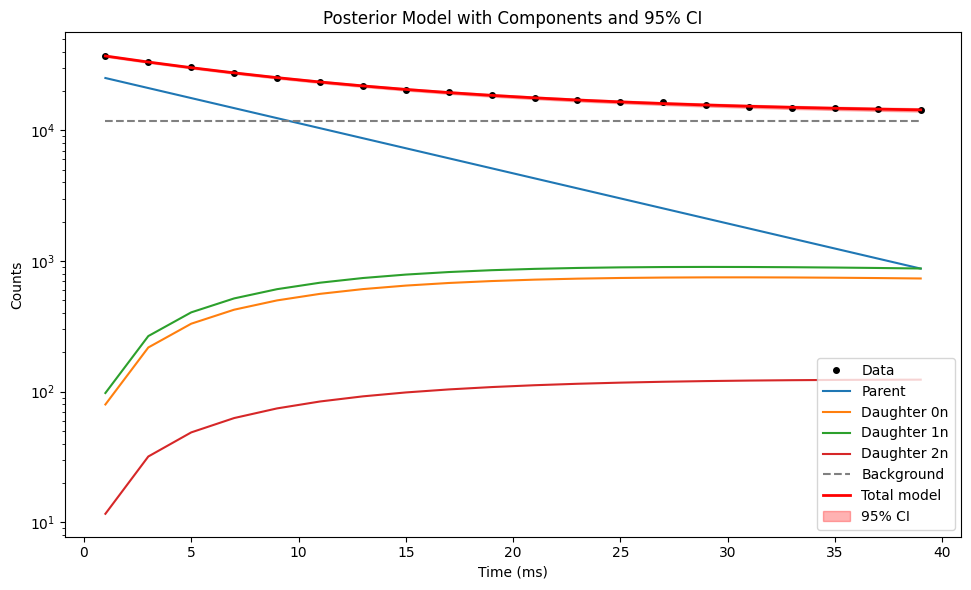

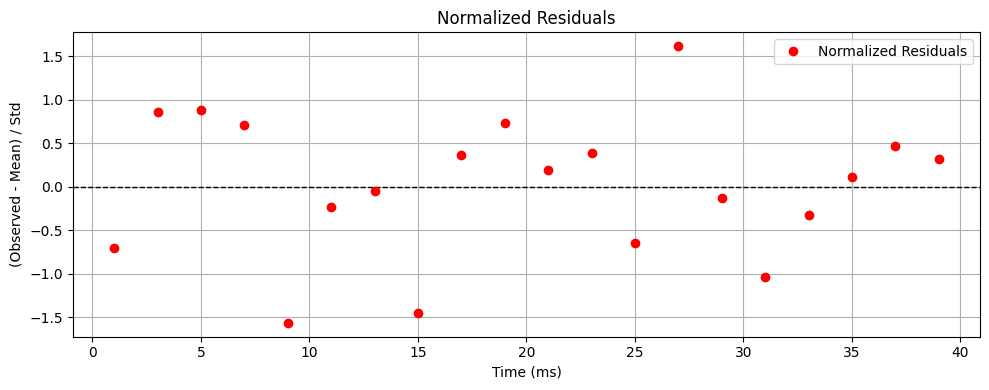

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import arviz as az

# Posterior extraction helper
posterior = bateman_trace.posterior
mean = lambda name: posterior[name].mean(dim=("chain", "draw")).values

# Posterior means
p_act = mean('initialActivity')
p_hl  = mean('parentT')
d0_hl = mean('daugh0nT')
d1_hl = mean('daugh1nT')
d2_hl = mean('daugh2nT')
# d0_hl = 90.2  # Uncomment if you want to use fixed
#d1_hl = 80.4
#d2_hl = 270

br1   = posterior['b1'].mean(dim=("chain", "draw")).values
br2   = posterior['b2'].mean(dim=("chain", "draw")).values
br0   = 1 - (br1 + br2)  # Ensure b0 is derived from b1 and b2
bkg   = mean('backgroundLevel')

# Evaluate model using your defined function
parent_y = parent(p_hl, p_act, x_decay)
d0n_y = daughter0n(d0_hl, p_hl, p_act, br0, x_decay)
d1n_y = daughter1n(d1_hl, p_hl, p_act, br1, x_decay)
d2n_y = daughter2n(d2_hl, p_hl, p_act, br2, x_decay)
bkg_y = np.ones_like(x_decay) * bkg
total_y = parent_y + d0n_y + d1n_y + d2n_y + bkg_y

# Posterior predictive samples
ppc = pm.sample_posterior_predictive(bateman_trace, model=model, var_names=["y_obs"], progressbar=False)
y_pred_samples = ppc.posterior_predictive['y_obs'].stack(sample=("chain", "draw")).values

# Compute 95% CI
y_lower = np.percentile(y_pred_samples, 2.5, axis=1)
y_upper = np.percentile(y_pred_samples, 97.5, axis=1)

# ---- 📈 Plot Components + CI ----
plt.figure(figsize=(10, 6))
plt.plot(x_decay, y, "ko", label="Data", markersize=4)
plt.plot(x_decay, parent_y, label="Parent")
plt.plot(x_decay, d0n_y, label="Daughter 0n")
plt.plot(x_decay, d1n_y, label="Daughter 1n")
plt.plot(x_decay, d2n_y, label="Daughter 2n")
plt.plot(x_decay, bkg_y, "--", color='gray', label="Background")
plt.plot(x_decay, total_y, "r", lw=2, label="Total model")
plt.fill_between(x_decay, y_lower, y_upper, color='red', alpha=0.3, label="95% CI")

plt.xlabel("Time (ms)")
plt.ylabel("Counts")
plt.title("Posterior Model with Components and 95% CI")
plt.legend()
plt.tight_layout()
plt.yscale("log")
plt.show()

# ---- 📉 Normalized Residuals ----
y_mean = np.mean(y_pred_samples, axis=1)
y_std = np.std(y_pred_samples, axis=1)
residuals = (y - y_mean) / y_std

plt.figure(figsize=(10, 4))
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.plot(x_decay, residuals, 'ro', label="Normalized Residuals")
plt.xlabel("Time (ms)")
plt.ylabel("(Observed - Mean) / Std")
plt.title("Normalized Residuals")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib as mpl
import corner
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# Create posterior DataFrame from trace
df = bateman_trace.posterior.stack(sample=("chain", "draw")).to_dataframe().reset_index()

# Optionally drop auxiliary dims
df_clean = df.drop(columns=["sample", "chain", "draw"], errors="ignore")

# Filter only relevant parameters
params = ["parentT", "daugh0nT", "daugh1nT", "daugh2nT", "b1", "b2", "backgroundLevel"]
df_filtered = df_clean[params].copy()
df_filtered["b0"] = 1 - df_filtered["b1"] - df_filtered["b2"]
df_filtered = df_filtered[df_filtered["b0"] >= 0]

corner.corner(
    df[["initialActivity", "parentT", "daugh0nT", "daugh1nT", "daugh2nT", "b1", "b2", "backgroundLevel"]],
    labels=["Initial Activity", "parent HL", "d0nT", "d1nT", "d2nT", "b1", "b2", "bg"],
    show_titles=True,
    title_fmt=".2f",
    smooth=1.0
)
plt.show()

corner.corner(
    df[["parentT", "daugh0nT", "daugh1nT", "daugh2nT", "b1", "b2", "backgroundLevel"]],
    labels=["parentT", "d0nT", "d1nT", "d2nT", "b1", "b2", "bg"],
    show_titles=True,
    title_fmt=".2f",
    smooth=1.0,
    color="royalblue",        # or "darkorange", "crimson", etc.
    fill_contours=True,
    contour_kwargs={"colors": ["royalblue"]},  # contour lines
    hist_kwargs={"color": "skyblue", "edgecolor": "black"}
)
plt.show()
# Define a colormap and normalize it

fig = corner.corner(
    df[["parentT", "daugh0nT", "daugh1nT", "daugh2nT", "b1", "b2", "backgroundLevel"]],
    labels=["parentT", "d0nT", "d1nT", "d2nT", "b1", "b2", "bg"],
    show_titles=True,
    title_fmt=".2f",
    smooth=1.0,
    fill_contours=True,       # fill enabled
    plot_density=True,
    plot_contours=False,      # disable conflicting contour lines
    hist_kwargs={"color": "gray", "edgecolor": "black"}
)

plt.show()


